# Second Competition: Modulation format classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import h5py

#import library
import tensorflow as tf
from tensorflow import keras
from scipy.signal import lfilter

Load datasets. They are stored as a pickle file.

The datasets are taken from https://www.deepsig.io/datasets (RML2016.10a.tar.bz2), which contains a variety of radio datasets that are available as open datasets. The (simplified and modified, already pre-processed) dataset contains traces of 128 complex samples (Inphase and Quadrature component) of received radio signals with different modulation formats and at different signal-to-noise ratios (SNRs). The goal is to estimate the modulation format and/or the SNR from the traces.

In [0]:
# Load training dataset
with open('Deepsig_dataset_train.pkl', "rb") as f:
    X_train = pickle.load(f)
    y_train = pickle.load(f)
    SNR_train = pickle.load(f)
    modulation_formats = pickle.load(f)
    
# Load validation dataset
with open('Deepsig_dataset_valid.pkl', "rb") as f:
    X_valid = pickle.load(f)
    y_valid = pickle.load(f)
    SNR_valid = pickle.load(f)    

Print modulation formats that are used:

In [4]:
print('Modulation formats: ', modulation_formats)

Modulation formats:  ['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']


The array `X_train` contains the traces (the examples). The corresponding labels (the modulation format) are given by `y_train` and the corresponding SNR is given in `SNR_train`. The label in `y_train` corresponds to one of the modulation formats in `modulation_formats`.

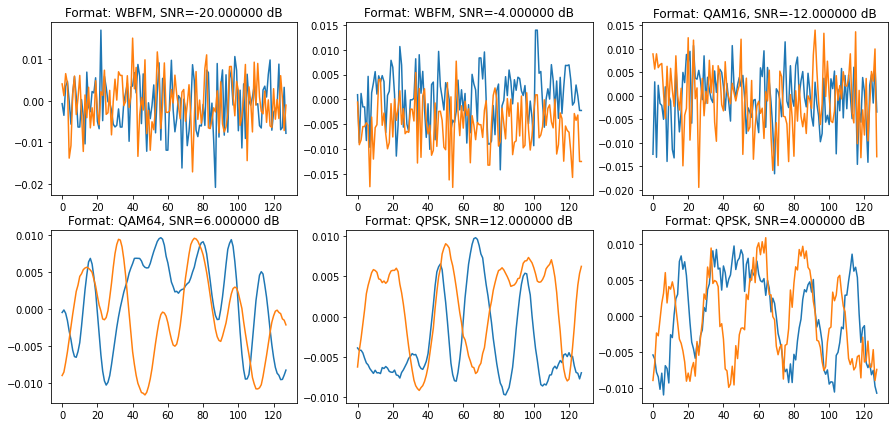

In [5]:
# plot 6 consecutive signal traces
starti = np.random.randint(0,X_train.shape[0]-7)
plt.figure(figsize=(15,7))
for k in range(6):
    plt.subplot(2,3,k+1)
    plt.plot(np.real(X_train[k+starti,:]))
    plt.plot(np.imag(X_train[k+starti,:]))
    plt.title('Format: %s, SNR=%f dB' % (modulation_formats[y_train[k+starti]], SNR_train[k+starti]))

## Task 1: Distinguish between BPSK and GFSK
You are given samples of an unknown modulation format and your task is to determine the modulation format in order to setup the receiver correctly. Try the following two options:
* Carry out the training separately for each SNR value, i.e., have one classifier for every SNR point
* Carry out the training jointly over all SNR values

Show the classification error for the validation set for each SNR point separately.

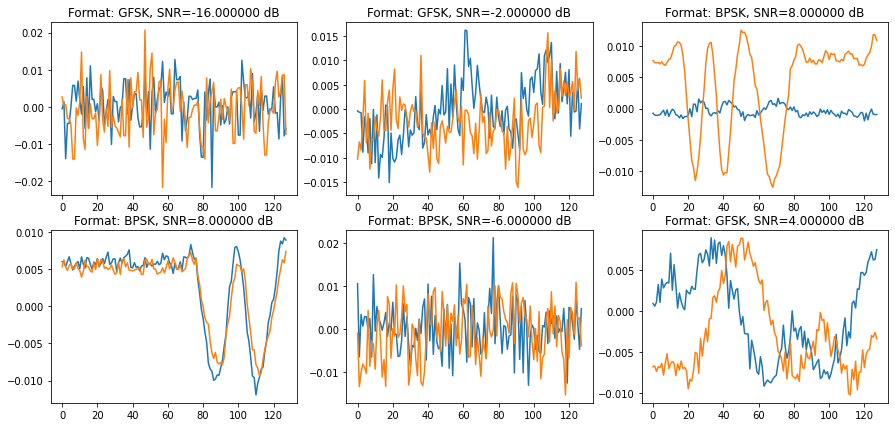

In [6]:
# generate Training set for Task 1
task1_modulation_formatidx = [i for i in range(len(modulation_formats)) if (modulation_formats[i] == 'BPSK' or modulation_formats[i] == 'GFSK')] 

task1_train_idx = [i for i in range(len(y_train)) if (y_train[i] == task1_modulation_formatidx[0] or y_train[i] == task1_modulation_formatidx[1])]
y_train_task1 = y_train[task1_train_idx]
X_train_task1 = X_train[task1_train_idx,:]
SNR_train_task1 = SNR_train[task1_train_idx]

task1_valid_idx = [i for i in range(len(y_valid)) if (y_valid[i] == task1_modulation_formatidx[0] or y_valid[i] == task1_modulation_formatidx[1])]
y_valid_task1 = y_valid[task1_valid_idx]
X_valid_task1 = X_valid[task1_valid_idx,:]
SNR_valid_task1 = SNR_valid[task1_valid_idx]

# plot 6 consecutive signal traces
starti = np.random.randint(0,X_train_task1.shape[0]-7)
plt.figure(figsize=(15,7))
for k in range(6):
    plt.subplot(2,3,k+1)
    plt.plot(np.real(X_train_task1[k+starti,:]))
    plt.plot(np.imag(X_train_task1[k+starti,:]))
    plt.title('Format: %s, SNR=%f dB' % (modulation_formats[y_train_task1[k+starti]], SNR_train_task1[k+starti]))

In [0]:
def CER(predictions, labels):
    return (np.sum(predictions != labels) / np.size(predictions))

In [0]:
# write your own classification algorithm here

# Part 1. Carry out the training separately for each SNR value, i.e., have one classifier for every SNR point

#first shape the data, convert input data from 128 complex number to 256 real number
#from 128 features to 256 features
#training and validation input data
X     = np.concatenate((X_train_task1.real,X_train_task1.imag),axis=1)
X     = X /X.max()                  #normalize the input training X.max()
X     = X.reshape(X.shape[0],256)
X_val = np.concatenate((X_valid_task1.real,X_valid_task1.imag),axis=1)
X_val = X_val/X_val.max()           #normalize the input validation
X_val = X_val.reshape(X_val.shape[0],256)

#label training and validation data
Y     = np.equal(y_train_task1,4)              #set 0 as BPSK and 1 as GFSK
Y     = Y.astype(float)                        #convert data type to float
Y     = Y.reshape(-1,1)                        #reshape the array
Y_val = np.equal(y_valid_task1,4)              #set 0 as BPSK and 1 as GFSK
Y_val = Y_val.astype(float)                    #convert data type to float
Y_val = Y_val.reshape(-1,1)                    #reshape the array

#variables
X_train_SNR=[]
X_valid_SNR=[]
Y_train_SNR=[]
Y_valid_SNR=[]

#divide the data base on SNR
SNR_range = np.unique(SNR_train_task1)        #range of SNR from -20 to 18dB
Error_rates = np.zeros(len(SNR_range))        #store the value of error rate for every SNR
Error_rates_train = np.zeros(len(SNR_range))  #Error rate training data

#callbacks function , stop the training when the desired loss is reached
class myCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs={}):
        if(logs.get('loss') < 0.0001):            
            self.model.stop_training = True
callbacks = myCallback()

#build the deep network model using keras
model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(X.shape[1], activation=tf.nn.relu), #input layer
        tf.keras.layers.Dense(128, activation=tf.nn.relu),        #first  hidden layer 128 node with relu activation 
        tf.keras.layers.Dense(32, activation=tf.nn.relu),         #second hidden layer 32 node with relu activation 
        tf.keras.layers.Dense(16, activation=tf.nn.relu),         #third  hidden layer 16 node with relu activation 
        tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)        #final output layer with sigmoid activation function
        ])

#build different model with convolutionanl neural network 
#the model with 1 dimension convolutional neural network
model_conv1D = tf.keras.models.Sequential([
             tf.keras.layers.Conv1D(64,4,activation = tf.nn.relu,   
             input_shape = (256,1) ),                              #input layer/convolutional layer 1
             tf.keras.layers.MaxPool1D(2),                         #pooling layer 1                        
             tf.keras.layers.Conv1D(64,4,activation = tf.nn.relu), #convolutional layer 2                       
             tf.keras.layers.MaxPool1D(2),                         #pooling layer 2                        
             tf.keras.layers.Conv1D(64,4,activation = tf.nn.relu), #convolutional layer 3                        
             tf.keras.layers.MaxPool1D(2),                         #pooling layer 3 
             #tf.keras.layers.Conv1D(32,4,activation = tf.nn.relu), #convolutional layer 4 
             #tf.keras.layers.MaxPool1D(2),                         #pooling layer 4
             tf.keras.layers.Flatten(),                            #flatten layer
             tf.keras.layers.Dense(16, activation = tf.nn.relu),   #fully connected layer
             tf.keras.layers.Dense(1, activation = tf.nn.sigmoid)  #final output layer with sigmoid activation
])
#model.summary()
#model_conv1D.summary()

In [0]:
#execute the learning phase
#loop over all SNR value
for idx,value in enumerate(SNR_range):
    #assign indices for every SNR value
    ids_train = [i for (i,val) in enumerate(SNR_train_task1) if np.abs(val-value) < 0.01]
    ids_valid = [i for (i,val) in enumerate(SNR_valid_task1) if np.abs(val-value) < 0.01]
    #divide data according to its SNR value    
  
    X_train_SNR = X[ids_train,:]
    X_valid_SNR = X_val[ids_valid,:]
    Y_train_SNR = Y[ids_train]
    Y_valid_SNR = Y_val[ids_valid]

    #X_train_SNR = X_train_SNR.reshape(X_train_SNR.shape[0],256)
    #X_valid_SNR = X_valid_SNR.reshape(X_valid_SNR.shape[0],256)
    #Y_train_SNR = Y_train_SNR.reshape(Y_train_SNR.shape[0],1)
    #Y_valid_SNR = Y_valid_SNR.reshape(Y_valid_SNR.shape[0],1)

    #compile the model  
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    #fit the model
    history = model.fit(
        X_train_SNR, Y_train_SNR, epochs = 40,callbacks=[callbacks]
    )
    #make prediction
    Y_pred = model.predict(X_valid_SNR)
    Y_pred = Y_pred > 0.5
    Y_pred = Y_pred.astype(float)
    Error_rates[idx] = CER(Y_pred,Y_valid_SNR)
    print(X_train_SNR.shape)
    print(Y_train_SNR.shape)
    print(X_valid_SNR.shape)
    print(Y_valid_SNR.shape)
    print(Y_pred.shape)
    print("error rate = "+str(CER(Y_pred,Y_valid_SNR)))



average error -20dB to -2dB = 0.3949471223937904
average error 0dB to 18dB   = 0.02681602112697463
average error -20dB to 18dB = 0.21088157176038247
Error rate -20 dB =0.5076452599388379
Error rate -18 dB =0.49851632047477745
Error rate -16 dB =0.48011363636363635
Error rate -14 dB =0.5079365079365079
Error rate -12 dB =0.5216049382716049
Error rate -10 dB =0.4325153374233129
Error rate -8 dB =0.4212121212121212
Error rate -6 dB =0.2732919254658385
Error rate -4 dB =0.18862275449101795
Error rate -2 dB =0.11801242236024845
Error rate 0 dB =0.10689655172413794
Error rate 2 dB =0.05245901639344262
Error rate 4 dB =0.02903225806451613
Error rate 6 dB =0.008982035928143712
Error rate 8 dB =0.00964630225080386
Error rate 10 dB =0.009230769230769232
Error rate 12 dB =0.015384615384615385
Error rate 14 dB =0.008955223880597015
Error rate 16 dB =0.003257328990228013
Error rate 18 dB =0.0243161094224924


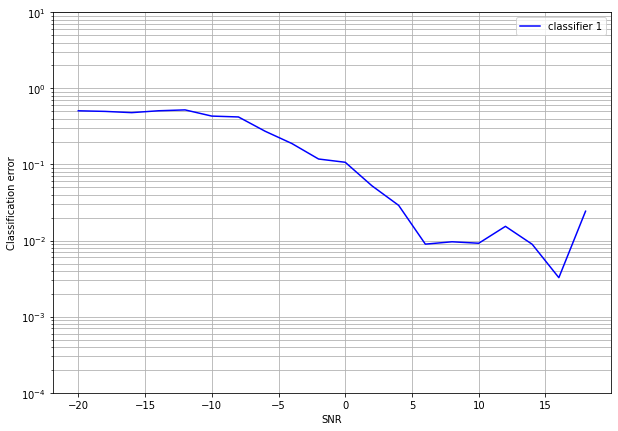

In [10]:
#Plot the classification error for each SNR value
print("average error -20dB to -2dB = "+str(np.mean(Error_rates[0:10])))
print("average error 0dB to 18dB   = "+str(np.mean(Error_rates[10:])))
print("average error -20dB to 18dB = "+str(np.mean(Error_rates)))

for i,val in enumerate(SNR_range):
    print("Error rate "+str(val)+" dB ="+str(Error_rates[i]))
#plot a figure
plt.figure(figsize=(10,7))
plt.plot(SNR_range, Error_rates,'b',label="classifier 1")
plt.legend()
plt.yscale('log')
plt.ylim([10e-5, 10e-0])
plt.xlabel('SNR')
plt.ylabel('Classification error')
plt.grid(which='both')
plt.show()

In [0]:
#Part 2. Carry out the training jointly over all SNR values

#build the 2nd model
#build 1Dimension Convolutional Neural Networks

X_2    = X.reshape(-1,256,1)
X_val2 = X_val.reshape(-1,256,1)
Y_2    = Y.reshape(-1,1)
Y_val2 = Y_val.reshape(-1,1)

model_conv1D_2 = tf.keras.models.Sequential([
             tf.keras.layers.Conv1D(64,4,activation = tf.nn.relu,   
             input_shape = (256,1) ),                              #input layer/convolutional layer 1
             tf.keras.layers.MaxPool1D(2),                         #pooling layer 1                        
             tf.keras.layers.Conv1D(64,4,activation = tf.nn.relu), #convolutional layer 2                       
             tf.keras.layers.MaxPool1D(2),                         #pooling layer 2                        
             tf.keras.layers.Conv1D(64,4,activation = tf.nn.relu), #convolutional layer 3                        
             tf.keras.layers.MaxPool1D(2),                         #pooling layer 3 
             tf.keras.layers.Conv1D(64,4,activation = tf.nn.relu), #convolutional layer 4 
             tf.keras.layers.MaxPool1D(2),                         #pooling layer 4
             tf.keras.layers.Flatten(),                            #flatten layer
             tf.keras.layers.Dense(32, activation = tf.nn.relu),   #fully connected layer
             tf.keras.layers.Dense(1, activation = tf.nn.sigmoid)  #final output layer with sigmoid activation
        ])

#compile the model
model_conv1D_2.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

#fit the model
history = model_conv1D_2.fit(
        X_2, Y_2, epochs = 100,callbacks=[callbacks]
    )

#summary of the model
model_conv1D_2





In [0]:
#save the model
#model_conv1D_2.save('/content/drive/My Drive/Colab Notebooks/Modulation_Classification/my_second_model.h5')


average error -20dB to -2dB = 0.3963213609801327
average error 0dB to 18dB   = 0.009522910457260371
average error -20dB to 18dB = 0.2029221357186965
Error rate -20 dB =0.5259938837920489
Error rate -18 dB =0.5014836795252225
Error rate -16 dB =0.4943181818181818
Error rate -14 dB =0.5079365079365079
Error rate -12 dB =0.49691358024691357
Error rate -10 dB =0.4601226993865031
Error rate -8 dB =0.41515151515151516
Error rate -6 dB =0.3105590062111801
Error rate -4 dB =0.18862275449101795
Error rate -2 dB =0.062111801242236024
Error rate 0 dB =0.013793103448275862
Error rate 2 dB =0.013114754098360656
Error rate 4 dB =0.012903225806451613
Error rate 6 dB =0.0029940119760479044
Error rate 8 dB =0.00964630225080386
Error rate 10 dB =0.009230769230769232
Error rate 12 dB =0.009230769230769232
Error rate 14 dB =0.011940298507462687
Error rate 16 dB =0.003257328990228013
Error rate 18 dB =0.00911854103343465


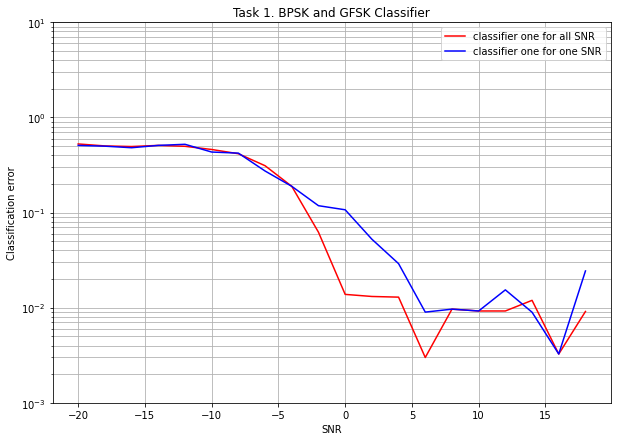

In [83]:
#evaluate and make a plot

Error_rates2 = np.zeros(len(SNR_range))  #error rates for model 2

#evaluate the model
#loop for every SNR
for idx,value in enumerate(SNR_range):
    #assign index according to its SNR
    ids_valid = [i for (i,val) in enumerate(SNR_valid_task1) if np.abs(val-value) < 0.01]

    X_valid_SNR = X_val2[ids_valid,:]
    Y_valid_SNR = Y_val2[ids_valid,:]
    
    #make a prediction
    Y_pred = model_conv1D_2.predict(X_valid_SNR)
    Y_pred = Y_pred > 0.5
    Y_pred = Y_pred.astype(float)
    Error_rates2[idx] = CER(Y_pred,Y_valid_SNR)
    #print("error rate "+ str(value)+" dB ="+str(CER(Y_pred,Y_valid_SNR)))
  
#Plot the classification error for each SNR value
print("average error -20dB to -2dB = "+str(np.mean(Error_rates2[0:10])))
print("average error 0dB to 18dB   = "+str(np.mean(Error_rates2[10:])))
print("average error -20dB to 18dB = "+str(np.mean(Error_rates2)))

for i,val in enumerate(SNR_range):
    print("Error rate "+str(val)+" dB ="+str(Error_rates2[i]))
#plot a figure
plt.figure(figsize=(10,7))
plt.title("Task 1. BPSK and GFSK Classifier")
plt.plot(SNR_range, Error_rates2,'r',label="classifier one for all SNR")
plt.plot(SNR_range, Error_rates,'b',label="classifier one for one SNR")
plt.legend()
plt.yscale('log')
plt.ylim([10e-4, 10e-0])
plt.xlabel('SNR')
plt.ylabel('Classification error')
plt.grid(which='both')
plt.show()

## Task 2: Classify modulation format
Design an ML system that estimates the modulation format from the traces (supervised learning, classification task). To evaluate the performance, carry out the classification separately for each SNR and show the performance for each SNR point.
* Carry out the training separately for each SNR value, i.e., have one classifier for every SNR point
* Carry out the training jointly over all SNR values

In [0]:
#classification of modulation format 
print(X_train.shape)
print(y_train.shape)

#prepare the data
X_train_task2 = np.concatenate((X_train.real,X_train.imag),axis=1)
X_train_task2 = X_train_task2/X_train_task2.max()
X_train_task2 = X_train_task2.reshape(-1,256,1)

X_valid_task2 = np.concatenate((X_valid.real,X_valid.imag),axis=1)
X_valid_task2 = X_valid_task2/X_valid_task2.max()
X_valid_task2 = X_valid_task2.reshape(-1,256,1)

Y_train_task2 = y_train.reshape(-1,1)
Y_valid_task2 = y_valid.reshape(-1,1)

print(X_train_task2.shape)
print(X_valid_task2.shape)
print(Y_train_task2.shape)
print(Y_valid_task2.shape)

#build the model 1 dimension convolutional neural network with 10 multiclass softmax activation function
model_conv1D_3 = tf.keras.models.Sequential([
             tf.keras.layers.Conv1D(256,4,activation = tf.nn.relu,   
             input_shape = (256,1) ),                              #input layer/convolutional layer 1                    
             tf.keras.layers.MaxPool1D(2),                         #pooling layer 1                        
             tf.keras.layers.Conv1D(80,4,activation = tf.nn.relu), #convolutional layer 2               
             tf.keras.layers.Dropout(0.5),
             tf.keras.layers.MaxPool1D(2),                         #pooling layer 2                        
             tf.keras.layers.Conv1D(80,4,activation = tf.nn.relu), #convolutional layer 3                                    
             tf.keras.layers.MaxPool1D(2),                         #pooling layer 3              
             tf.keras.layers.Flatten(),                            #flatten layer
             tf.keras.layers.Dense(512, activation = tf.nn.relu),   #fully connected layer             
             tf.keras.layers.Dense(256, activation = tf.nn.relu),   #fully connected layer            
             tf.keras.layers.Dense(128, activation = tf.nn.relu),   #fully connected layer
             tf.keras.layers.Dense(10, activation =  tf.nn.softmax)  #final output layer with softmax activation
        ])

#summary of the model
model_conv1D_3.summary()

#compile the model
model_conv1D_3.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

#fit the model
history = model_conv1D_3.fit(
        X_train_task2, Y_train_task2, epochs = 100,callbacks=[callbacks]
    )

#save the model
#model_conv1D_3.save('/content/drive/My Drive/Colab Notebooks/Modulation_Classification/my_third_model.h5')

average error -20dB to -2dB = 0.7423146579479875
average error 0dB to 18dB   = 0.23122865143003274
average error -20dB to 18dB = 0.4867716546890102
Error rate3 -20 dB =0.9074664964901085
Error rate3 -18 dB =0.8919254658385093
Error rate3 -16 dB =0.8882716049382716
Error rate3 -14 dB =0.8601307189542484
Error rate3 -12 dB =0.8627935723114957
Error rate3 -10 dB =0.7946317103620475
Error rate3 -8 dB =0.726027397260274
Error rate3 -6 dB =0.6429503916449086
Error rate3 -4 dB =0.47799132052076876
Error rate3 -2 dB =0.37095790115924343
Error rate3 0 dB =0.30363036303630364
Error rate3 2 dB =0.26180257510729615
Error rate3 4 dB =0.22732769044740025
Error rate3 6 dB =0.23003194888178913
Error rate3 8 dB =0.23118603251053582
Error rate3 10 dB =0.20051914341336793
Error rate3 12 dB =0.2092739475289811
Error rate3 14 dB =0.23072177668106109
Error rate3 16 dB =0.21432983323038912
Error rate3 18 dB =0.20346320346320346


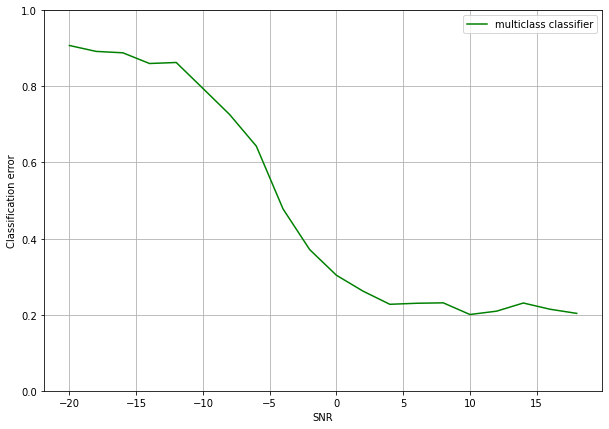

In [87]:
#evaluate and make a plot

Error_rates3 = np.zeros(len(SNR_range))  #error rates for model 2

#evaluate the model
#model_conv1D_3 = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/Modulation_Classification/my_third_model_2nd_run.h5')
#loop for every SNR
for idx,value in enumerate(SNR_range):
    #assign index according to its SNR
    ids_valid = [i for (i,val) in enumerate(SNR_valid) if np.abs(val-value) < 0.01]

    X_valid_SNR = X_valid_task2[ids_valid,:]
    Y_valid_SNR = Y_valid_task2[ids_valid,:]
    
    #make a prediction
    Y_pred = model_conv1D_3.predict(X_valid_SNR)
    Y_pred = np.argmax(Y_pred,axis=1)
    Y_pred = Y_pred.reshape(-1,1)
    Error_rates3[idx]=CER(Y_pred,Y_valid_SNR)
  
#Plot the classification error for each SNR value
print("average error -20dB to -2dB = "+str(np.mean(Error_rates3[0:10])))
print("average error 0dB to 18dB   = "+str(np.mean(Error_rates3[10:])))
print("average error -20dB to 18dB = "+str(np.mean(Error_rates3)))

for i,val in enumerate(SNR_range):
  print("Error rate3 "+str(val)+" dB ="+str(Error_rates3[i]))

#plot a figure
plt.figure(figsize=(10,7))
plt.plot(SNR_range, Error_rates3,'g',label="multiclass classifier")
plt.legend()
plt.ylim([0, 1])
plt.xlabel('SNR')
plt.ylabel('Classification error')
plt.grid(which='both')
plt.show()


In [72]:
print(X_train_task2.reshape(-1,256).shape)
print(Y_train_task2.shape)
print(X_valid_task2.reshape(-1,256).shape)
print(Y_valid_task2.shape)

(128000, 256)
(128000, 1)
(32000, 256)
(32000, 1)


In [0]:
#Task 2 
#Part 1. Carry out the training separately for each SNR value, i.e., have one classifier for every SNR point
Error_rates4 = np.zeros(len(SNR_range))
#build the deep network model using keras
model_dnn_task2 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(X.shape[0], activation=tf.nn.relu), #input layer
        tf.keras.layers.Dense(128, activation=tf.nn.relu),        
        tf.keras.layers.Dense(64, activation=tf.nn.relu),         #second hidden layer 64 node with relu activation 
        tf.keras.layers.Dense(32, activation=tf.nn.relu),         #third  hidden layer 32 node with relu activation 
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)        #final output layer with 10 softmax function
        ])


#loop over SNR
for idx,value in enumerate(SNR_range):
    #assign indices for every SNR value
    ids_train = [i for (i,val) in enumerate(SNR_train) if np.abs(val-value) < 0.01]
    ids_valid = [i for (i,val) in enumerate(SNR_valid) if np.abs(val-value) < 0.01]

    #assign the training and validation data according to its SNR value
    X_train_SNR2 = X_train_task2[ids_train,:]
    Y_train_SNR2 = Y_train_task2[ids_train,:]
    X_valid_SNR2 = X_valid_task2[ids_valid,:]    
    Y_valid_SNR2 = Y_valid_task2[ids_valid,:]

    X_train_SNR2 = X_train_SNR2.reshape(-1,256)
    X_valid_SNR2 = X_valid_SNR2.reshape(-1,256)

    #compile the model
    model_dnn_task2.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    #fit the model
    history = model_dnn_task2.fit(
        X_train_SNR2, Y_train_SNR2, epochs = 50,callbacks=[callbacks]
    )
    #make a prediction
    Y_pred = model_dnn_task2.predict(X_valid_SNR2)
    Y_pred = np.argmax(Y_pred,axis=1)
    Y_pred = Y_pred.reshape(-1,1)
    Error_rates4[idx]=CER(Y_pred,Y_valid_SNR2)



average error -20dB to -2dB = 0.7396299828396227
average error 0dB to 18dB   = 0.4162045669868591
average error -20dB to 18dB = 0.5779172749132409
Error rate4 -20 dB =0.8959795788130185
Error rate4 -18 dB =0.9
Error rate4 -16 dB =0.9024691358024691
Error rate4 -14 dB =0.8699346405228758
Error rate4 -12 dB =0.8139678615574784
Error rate4 -10 dB =0.7459425717852685
Error rate4 -8 dB =0.6413449564134496
Error rate4 -6 dB =0.5842036553524804
Error rate4 -4 dB =0.5610663360198388
Error rate4 -2 dB =0.48139109212934716
Error rate4 0 dB =0.44686468646864685
Error rate4 2 dB =0.45187001839362356
Error rate4 4 dB =0.4498186215235792
Error rate4 6 dB =0.4083067092651757
Error rate4 8 dB =0.42624924744130044
Error rate4 10 dB =0.3900064892926671
Error rate4 12 dB =0.3746186699206833
Error rate4 14 dB =0.41147439851943246
Error rate4 16 dB =0.4064237183446572
Error rate4 18 dB =0.396413110698825


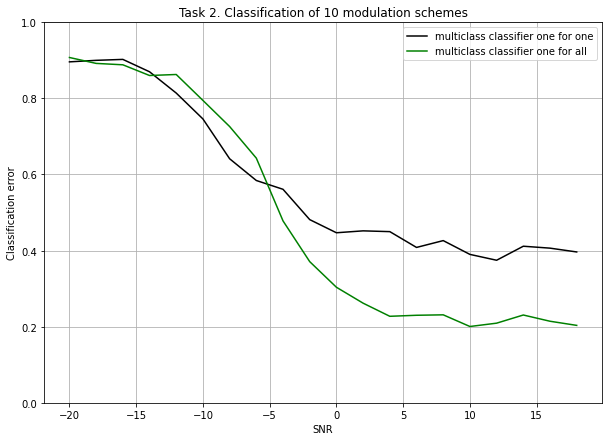

In [91]:
#Plot the classification error for each SNR value
print("average error -20dB to -2dB = "+str(np.mean(Error_rates4[0:10])))
print("average error 0dB to 18dB   = "+str(np.mean(Error_rates4[10:])))
print("average error -20dB to 18dB = "+str(np.mean(Error_rates4)))

for i,val in enumerate(SNR_range):
  print("Error rate4 "+str(val)+" dB ="+str(Error_rates4[i]))

#plot a figure
plt.figure(figsize=(10,7))
plt.title("Task 2. Classification of 10 modulation schemes")
plt.plot(SNR_range, Error_rates4,'k',label="multiclass classifier one for one")
plt.plot(SNR_range, Error_rates3,'g',label="multiclass classifier one for all")
plt.legend()
plt.ylim([0, 1])
plt.xlabel('SNR')
plt.ylabel('Classification error')
plt.grid(which='both')
plt.show()

## Task 3: Determine SNR
Determine the SNR from the examples (supervised learning, classification task)

## Task 4: Cluster the traces
Try if clustering is successful and if you can group examples that share similar properties (e.g., modulation format and SNR)